In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Project Description: The goal of this project is to investigate the possibility of predicting a penalty kick in soccer. For this project, we focus first on classifying the intent of the kicker (e.g. is she kicking to the left, right, low_center, or high_center) by analyzing the variation of ACC data measured by the Empatica band attached to the kickers ankle. This notebook demonstrates that classification of penalty kick intent is possible, and potential future directions of this investigation are described at the end of the notebook.

### Experimental Set-Up: The initial intent was to divide a soccer goal into a grid of 6 targets, but, for simplicity and due to other constraints (individual project, lack of available soccer team for data generation), the data was generated by: 1) Adjusting the Empatica band firmly on my ankle with a physical therapy band and 2) continously executing 14-15 kicks rebounding off a wall in each of the 4 directions while wearing the Empatica band from around 2/3 the distance of a normal penalty kick (normal penalty kick is 11 meters).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal as signal
import peakutils
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [3]:
# CELL CONTAINING FUNCTIONS TO BE USED

def ACC_plot(trials_file,plot_title, color, plot=True):
    trials = pd.read_csv(trials_file, delimiter = ",")
    if plot == True:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=trials.iloc[:,0], ys=trials.iloc[:,1], zs=trials.iloc[:,2], zdir='z', s=20, c=color, depthshade=True)
        fig.suptitle(plot_title, fontsize=20)
    return trials

def ACC_mag_plot(trials, title,noisy=False,plot=True,plot_color=None):
    time = trials.shape[0] / 32
    t_l = np.linspace(0, time, trials.shape[0])
    trials_mag = (np.sqrt((trials** 2).sum(axis = 1))).values
    
    if noisy == True:        
        fig = plt.figure(figsize=(20, 5))
        plt.plot(t_l, trials_mag,plot_color)
        plt.plot(t_l[(53*32):(62*32)], trials_mag[(53*32):(62*32)],'black')
        plt.plot(t_l[(96*32):(124*32)], trials_mag[(96*32):(124*32)],'black')
        plt.plot(t_l[(137*32):(162*32)], trials_mag[(137*32):(162*32)],'black')
        plt.plot(t_l[(172*32):], trials_mag[(172*32):],'black')
        plt.title(title)
        plt.xlabel("time/s")
        plt.ylabel("magnitude")
        red_patch = mpatches.Patch(color='black', label='to be removed')
        plt.legend(handles=[red_patch])
        plt.show()
        return trials_mag, t_l
        
    if plot == True:
        fig = plt.figure(figsize=(20, 5))
        if plot_color==None:
            plt.plot(t_l, trials_mag)
        else:
            plt.plot(t_l, trials_mag,plot_color)
        plt.title(title)
        plt.xlabel("time/s")
        plt.ylabel("magnitude")
        plt.show()
    return trials_mag, t_l

def get_template(trials,time,t1,t2,title,left=False,plot=True,plot_color=None):
    if left == True:
        template = trials[(t1):(t2)]
        temp_t = time[(t1):(t2)]
    else:
        template = trials[(t1*32):(t2*32)]
        temp_t = time[(t1*32):(t2*32)]
    if plot == True:
        fig = plt.figure(figsize=(20, 5))
        if plot_color==None:
            plt.plot(temp_t, template)
        else:
            plt.plot(temp_t, template,plot_color)
        plt.title(title)
        plt.xlabel("time/s")
        plt.ylabel("magnitude")
        plt.show()
    return template

def convolve_trials(template,trials,plot_color,title,left=False,plot=True):
    conv_trials = signal.convolve(template,trials)
    if left == True:
        indexes = peakutils.indexes(y=conv_trials, thres=0.6, min_dist=50)
    else:
        indexes = peakutils.indexes(y=conv_trials, thres=0.75, min_dist=50)

    if plot == True:
        time = conv_trials.shape[0] / 32
        t = np.linspace(0, time, conv_trials.shape[0])
        fig = plt.figure(figsize=(20, 5))
        plt.plot(t, conv_trials,plot_color)
        plt.title(title)
        plt.xlabel("time/s")
        plt.ylabel("magnitude")
        if left == True:
            plt.plot(t[indexes],conv_trials[indexes],'ro')
        else:
            plt.plot(t[indexes],conv_trials[indexes],'bo')
        plt.show()
    return conv_trials, indexes

def stack_kicks(conv_trials,indexes,title):
    kicks = np.matrix(conv_trials[(indexes[0]-50):(indexes[0]+50)])
    for i in range(indexes.shape[0]-1):
        kicks = np.concatenate((kicks, np.matrix(conv_trials[(indexes[i+1]-50):(indexes[i+1]+50)])),axis=0)

    ts = kicks.shape[1] / 32
    times = np.linspace(0, ts, kicks.shape[1])

    fig = plt.figure(figsize=(20, 5))
    for i in range(kicks.shape[0]):
        plt.plot(times, kicks[i].T)
    plt.title(title)
    plt.xlabel("time/s")
    plt.ylabel("magnitude")
    plt.show()
    print("Number of Kicks:", kicks.shape[0])
    return kicks

def del_noisy_high_kicks(noisy_trials,plot_color):
    kept = np.hstack((noisy_trials[:(53*32)],
                  noisy_trials[(62*32):(96*32)],
                  noisy_trials[(124*32):(137*32)],
                  noisy_trials[(162*32):(172*32)]))
    t = noisy_trials.shape[0] / 32
    times = np.linspace(0, t, kept.shape[0])

    fig = plt.figure(figsize=(20, 5))
    plt.plot(times, kept,plot_color)
    plt.title("ACC Magnitude 14 High Kicks")
    plt.xlabel("time/s")
    plt.ylabel("magnitude")
    plt.show()
    return kept,times

def PCA_eig(trials_tuple,title1,title2,threes=False):
    X = np.vstack(trials_tuple)
    mu = np.mean(X,axis=0)
    mu1 = np.repeat(mu, X.shape[0], axis=0)
    C = (X - mu1).T.dot((X-mu1))

    D, U = np.linalg.eig(C)
    plt.figure(figsize=(10,5))
    plt.plot(np.real(D))
    plt.xlabel('Eigenvalue number')
    plt.ylabel('Eigenvalue value')
    plt.title(title1)
    plt.show()
    
    if threes != True:
        U=np.real(U)
        projected = X*U[:2].T
        plt.plot(projected)
        plt.xlabel('x shots')
        plt.ylabel('y')
        plt.title(title2)
        plt.show()

    projected_e3d = X*U[:3].T
    xeig=np.squeeze(np.asarray(projected_e3d[:,0]))
    yeig=np.squeeze(np.asarray(projected_e3d[:,1]))
    zeig=np.squeeze(np.asarray(projected_e3d[:,2]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=xeig, ys=yeig, zs=zeig, zdir='z', s=20, c=None, depthshade=True)
    fig.suptitle(title2, fontsize=20)
    
def PCA_svd(trials_tuple,title1,title2,threes=False):
    X = np.vstack(trials_tuple)
    mu = np.mean(X,axis=0)
    mu1 = np.repeat(mu, X.shape[0], axis=0)
    C = (X - mu1).T.dot((X-mu1))
    
    Y,S,V=np.linalg.svd(C)

    plt.figure(figsize=(10,5))
    plt.plot(np.real(S))
    plt.xlabel('sv number')
    plt.ylabel('sv value')
    plt.title(title1)
    plt.show()
    
    if threes != True:
        projected3 = X*V[:2].T
        plt.plot(projected3)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(title2)
        plt.show()
    
    projected3_3d = X*V[:3].T
    xsvd2=np.squeeze(np.asarray(projected3_3d[:,0]))
    ysvd2=np.squeeze(np.asarray(projected3_3d[:,1]))
    zsvd2=np.squeeze(np.asarray(projected3_3d[:,2]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=xsvd2, ys=ysvd2, zs=zsvd2, zdir='z', s=20, c=None, depthshade=True)
    fig.suptitle(title2, fontsize=20)

def LDA(trials_tuple):
    X = np.vstack(trials_tuple)
    mu_X = np.mean(X,axis=0).reshape([-1,1])
    S = np.zeros((X.shape[1],X.shape[1]))
    A = np.zeros((X.shape[1],X.shape[1]))
    
    for i in trials_tuple:
        S += np.cov(i.T)*i.shape[0]
        mu_i = (np.mean(i, axis = 0).reshape([-1,1]))
        A += ((mu_i - mu_X).dot((mu_i - mu_X).T))*i.shape[0]
        
    D, U = np.linalg.eig(np.linalg.inv(S).dot(A))
    return U

### For each direction (right, left, center_low, and center_high), I 1) plot the raw ACC data, 2) plot the ACC magnitude, 3) choose a template for the kick signature, 4) convolve each signature with each of the 14-15 trials, 5) run a peakfinder on the enhanced signals, 6) use these peaks to create an example for each kick of 100 samples centered at the peak, and 7) plot the stacked 100-sample example kicks.

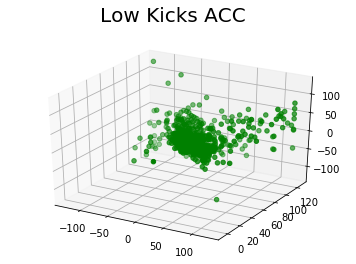

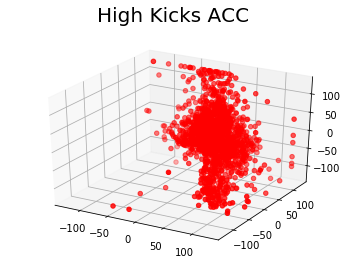

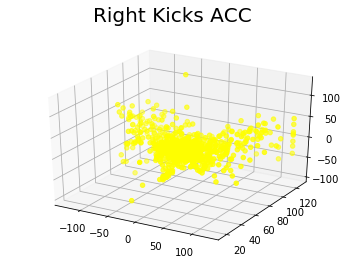

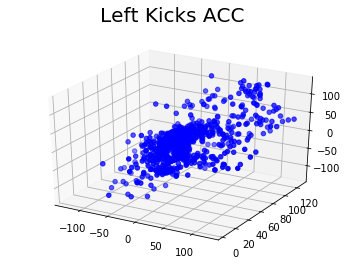

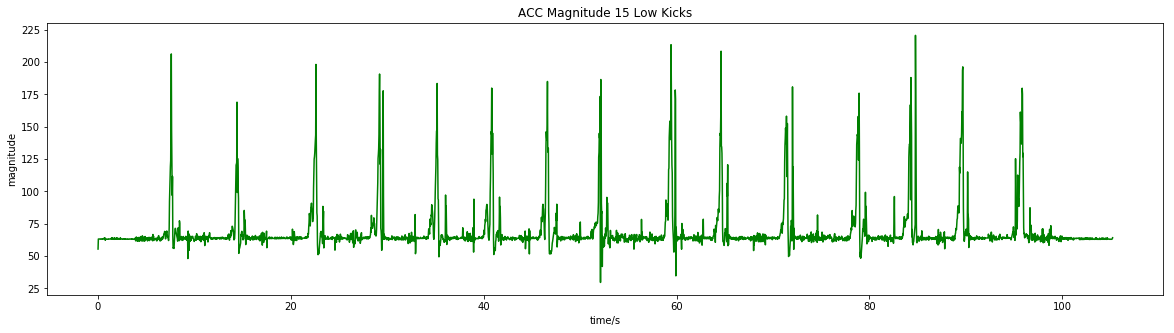

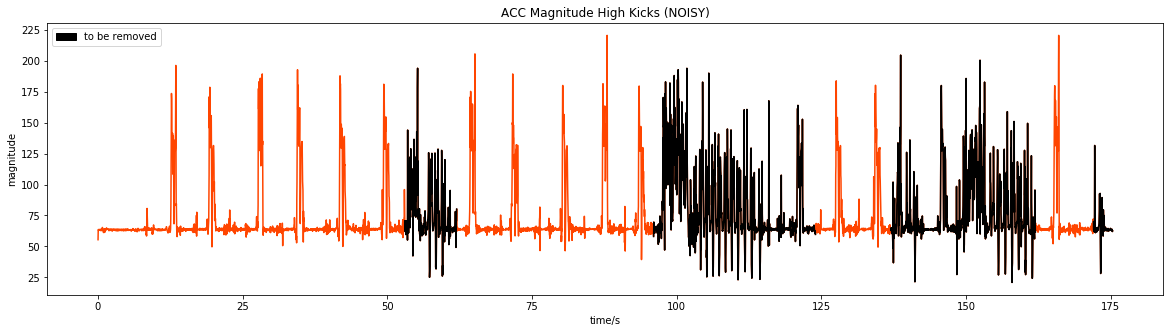

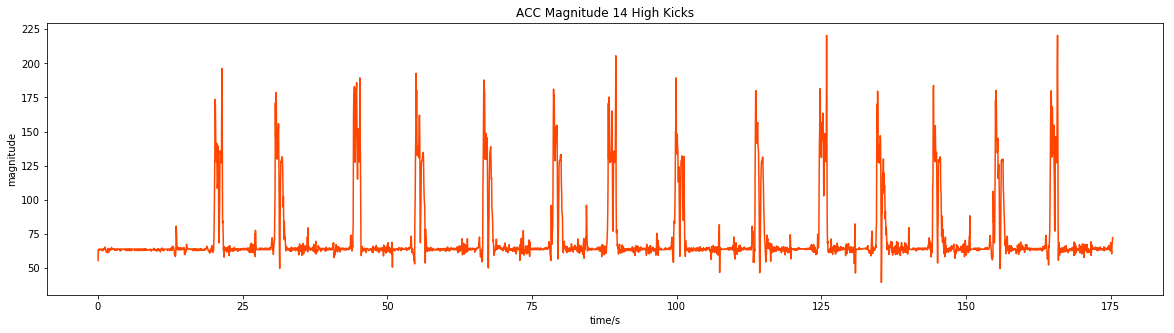

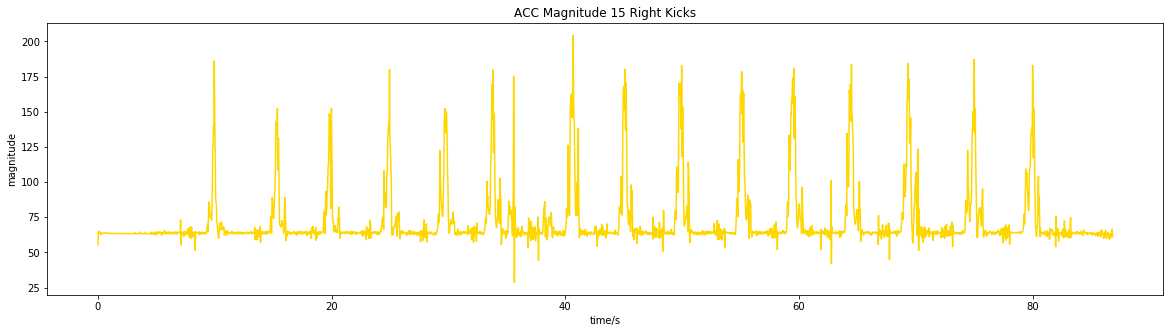

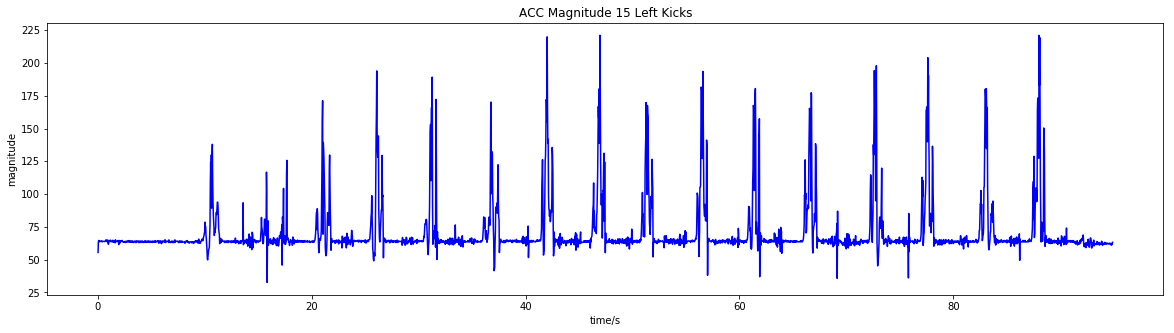

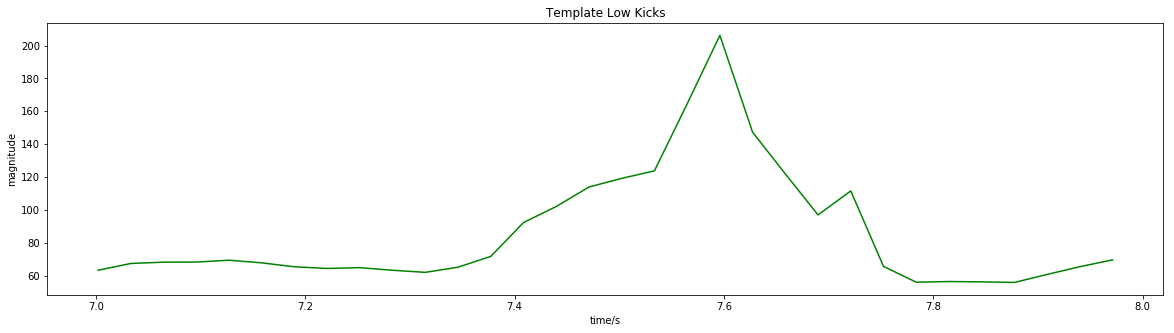

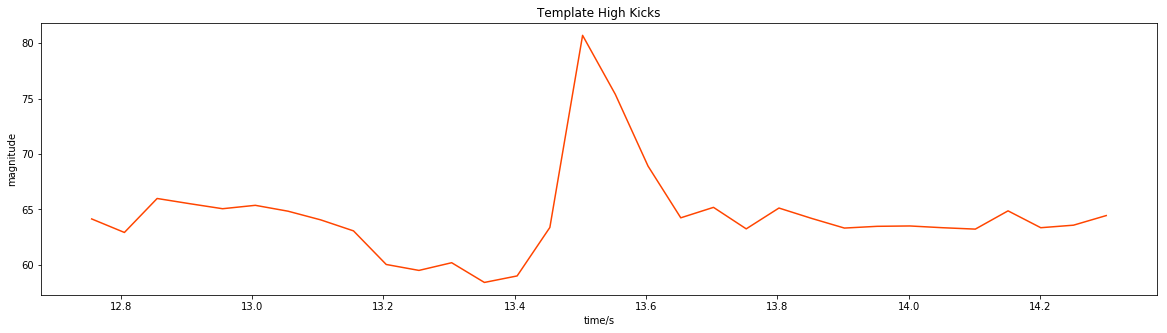

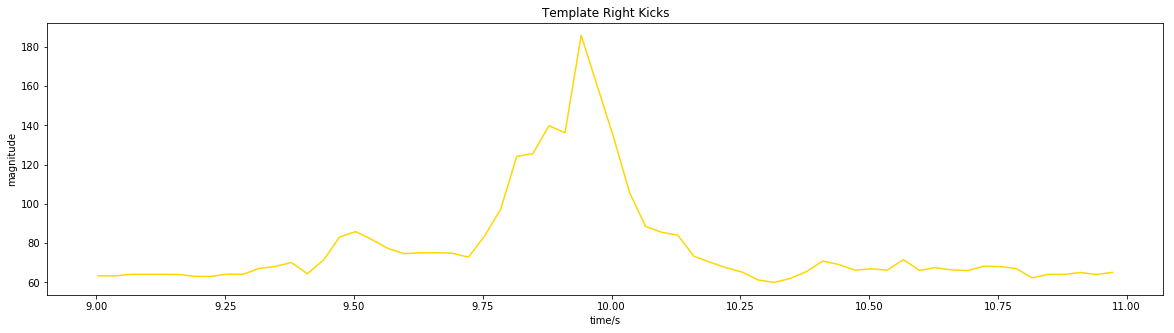

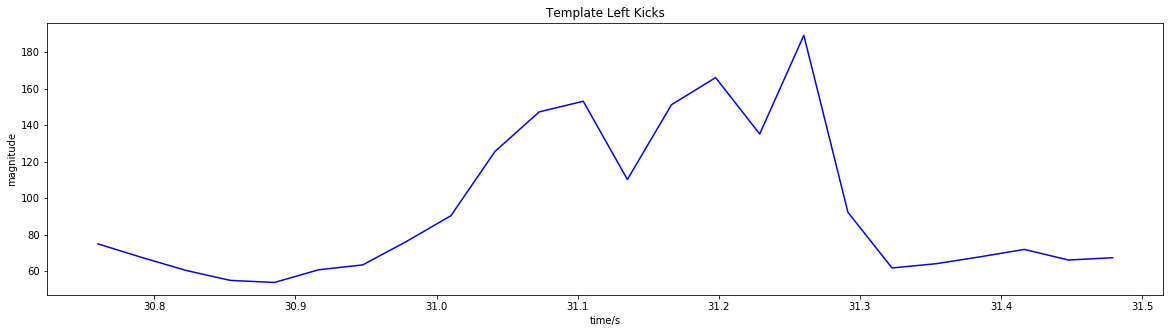

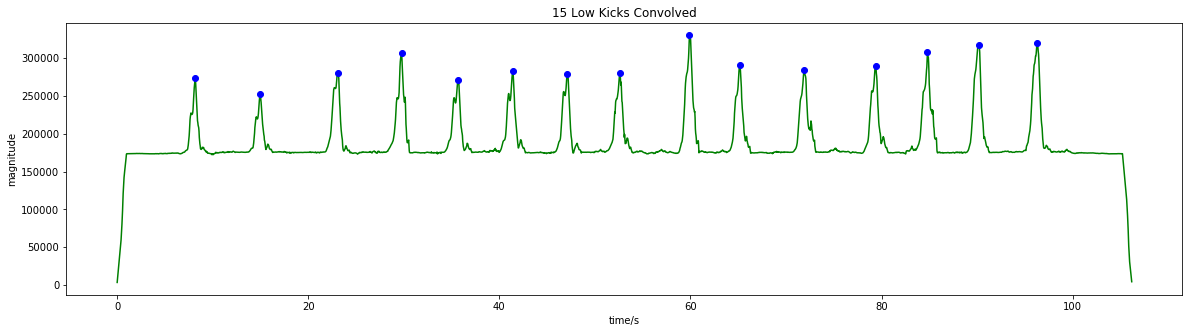

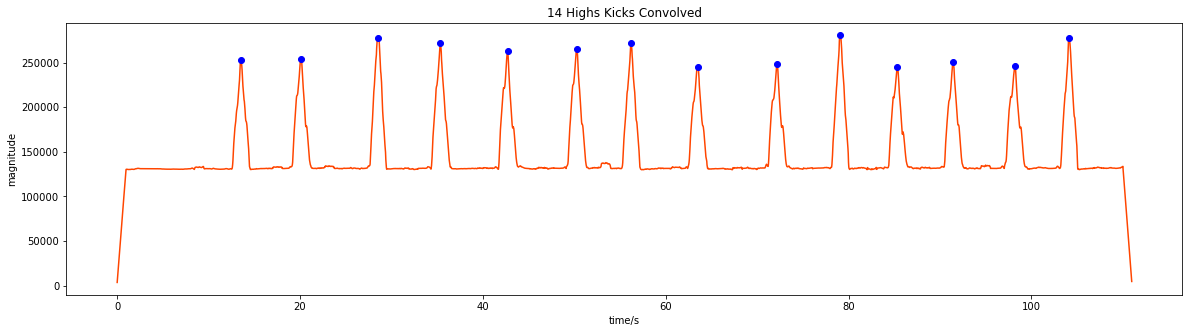

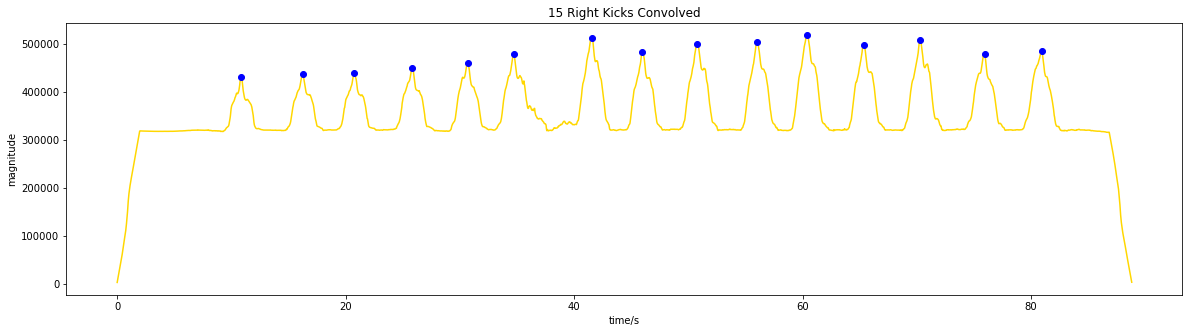

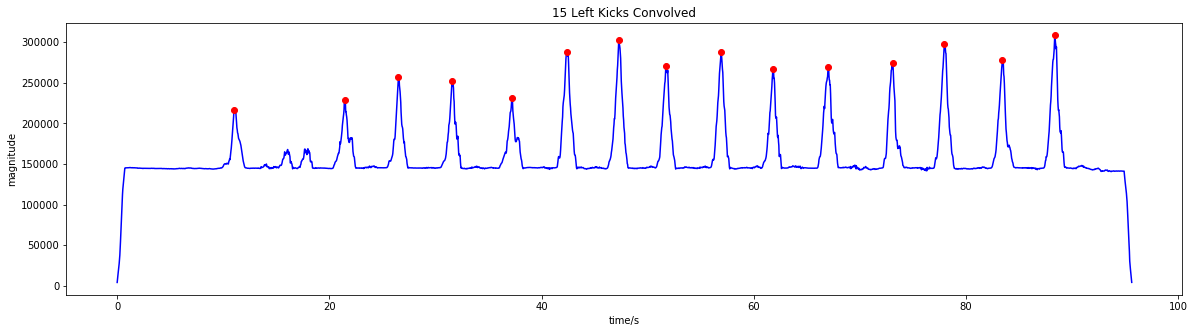

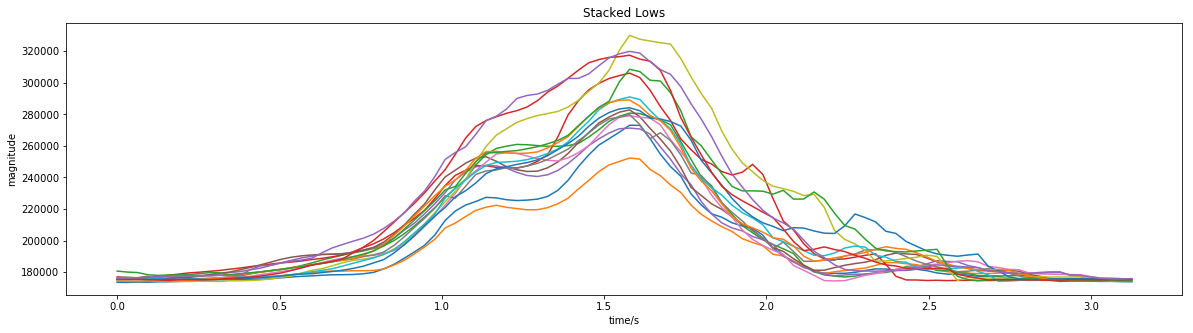

Number of Kicks: 15


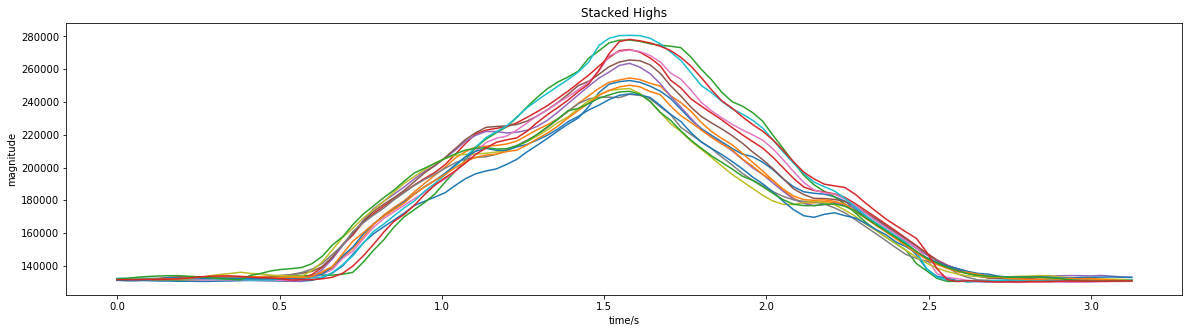

Number of Kicks: 14


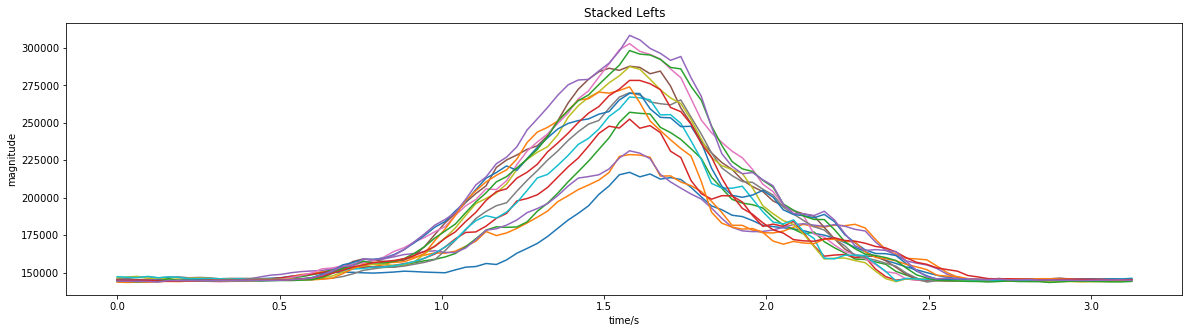

Number of Kicks: 15


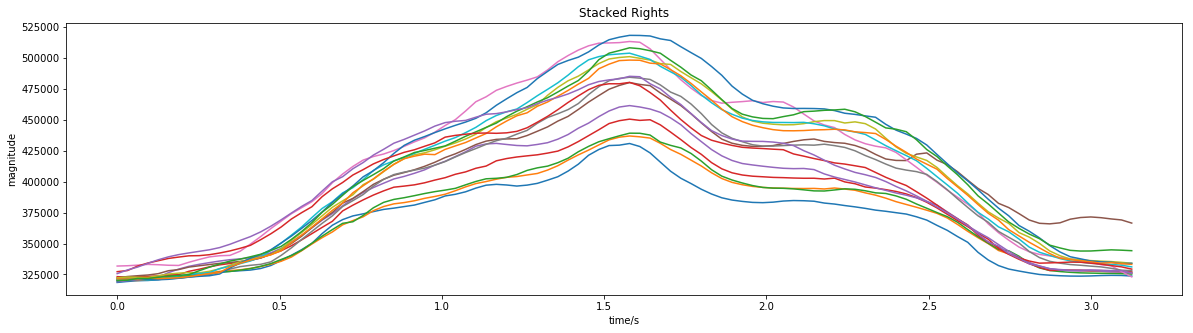

Number of Kicks: 15


In [4]:
fift_low = ACC_plot("15_low1_ACC.csv",'Low Kicks ACC','green')
fift_high = ACC_plot("15_high1_ACC.csv",'High Kicks ACC','red')
fift_rights = ACC_plot("fift_right1_ACC.csv",'Right Kicks ACC','yellow')
fift_left = ACC_plot("fift_left1_ACC.csv",'Left Kicks ACC','blue')

fift_low_mag,time_lows = ACC_mag_plot(fift_low,"ACC Magnitude 15 Low Kicks",plot_color='green')
fift_high_mag,time_highs = ACC_mag_plot(fift_high,"ACC Magnitude High Kicks (NOISY)",noisy=True,plot_color='orangered')
fift_high_mag,time_highs = del_noisy_high_kicks(fift_high_mag,plot_color='orangered')
fift_rights_mag,time_rights = ACC_mag_plot(fift_rights,"ACC Magnitude 15 Right Kicks",plot_color='gold')
fift_lefts_mag,time_lefts = ACC_mag_plot(fift_left,"ACC Magnitude 15 Left Kicks",plot_color='blue')

template_low = get_template(fift_low_mag,time_lows,7,8,"Template Low Kicks",plot_color='green')
template_high = get_template(fift_high_mag,time_highs,8,9,"Template High Kicks",plot_color='orangered')
template_right = get_template(fift_rights_mag,time_rights,9,11,"Template Right Kicks",plot_color='gold')
template_left = get_template(fift_lefts_mag,time_lefts,984,1008,"Template Left Kicks",left=True,plot_color='blue')

low_conv,ind_low = convolve_trials(template_low,fift_low_mag,title="15 Low Kicks Convolved",plot_color='green')
high_conv, ind_high = convolve_trials(template_high,fift_high_mag,title="14 Highs Kicks Convolved",plot_color='orangered')
right_conv, ind_right = convolve_trials(template_right,fift_rights_mag,title="15 Right Kicks Convolved",plot_color='gold')
left_conv, ind_left = convolve_trials(template_left,fift_lefts_mag,title="15 Left Kicks Convolved",
                                      left=True,plot_color='blue')
lows = stack_kicks(low_conv,ind_low,"Stacked Lows")
highs = stack_kicks(high_conv,ind_high,"Stacked Highs")
lefts = stack_kicks(left_conv,ind_left,"Stacked Lefts")
rights = stack_kicks(right_conv,ind_right,"Stacked Rights")

### Iteratively perform and plot PCA (using eigendecomposition) for each of the 6 pairs from (right,left,center_low, and center_high kicks).

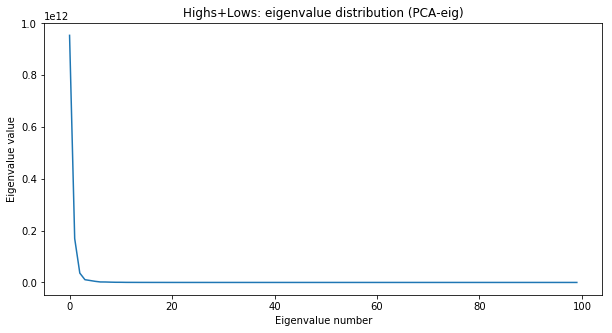

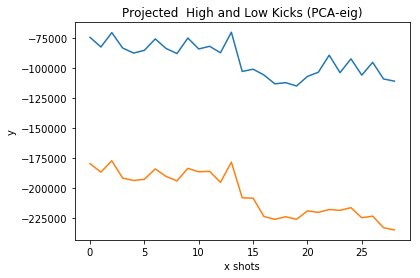

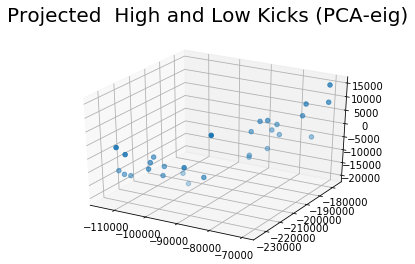

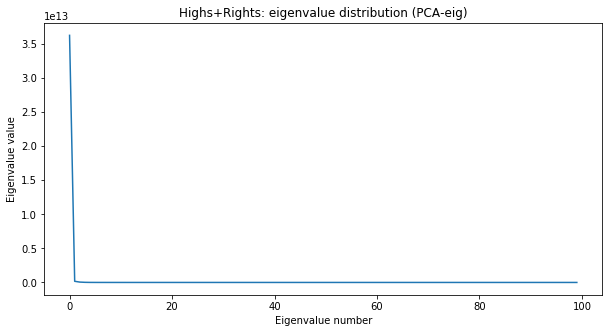

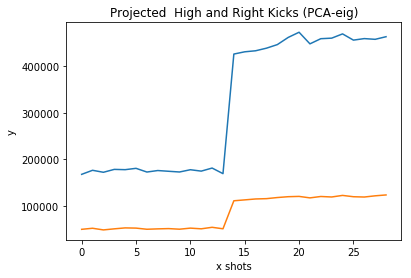

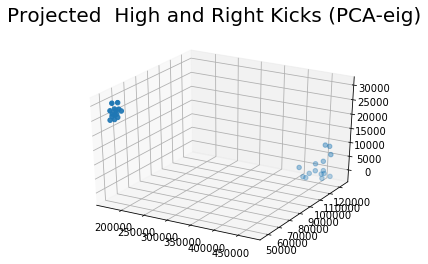

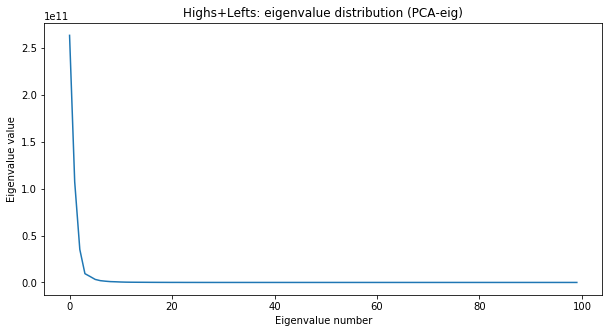

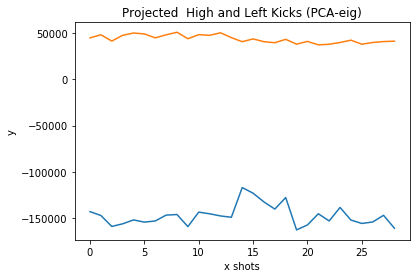

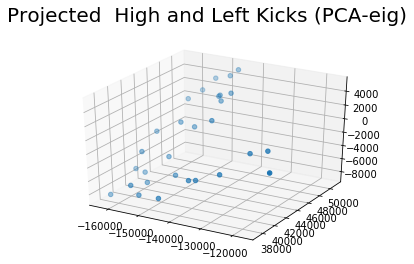

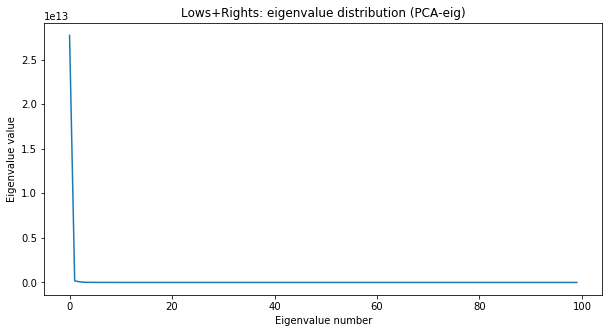

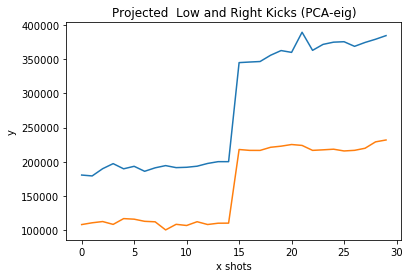

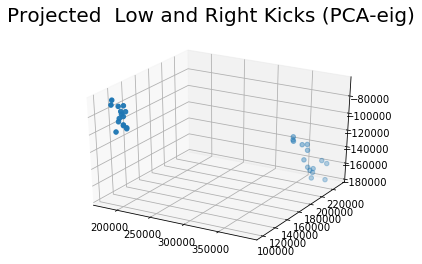

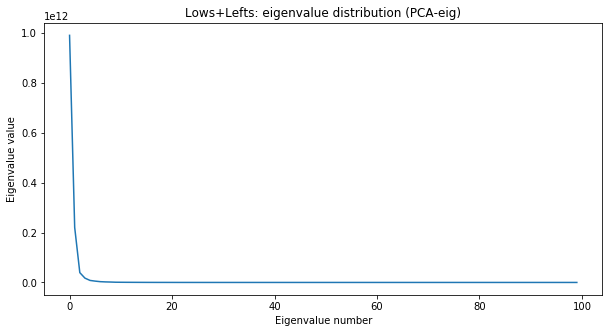

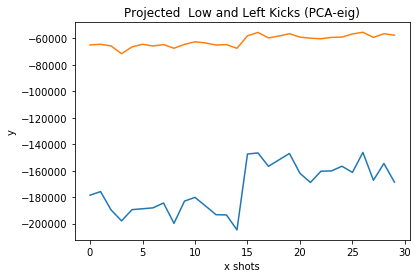

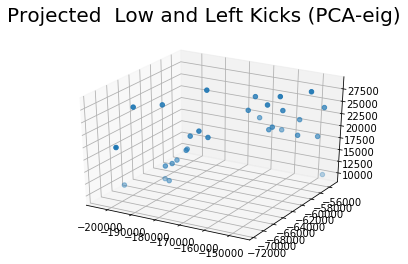

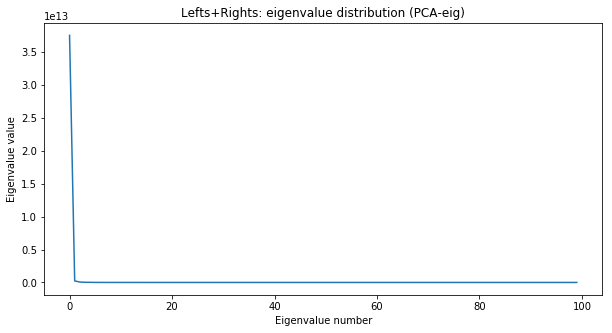

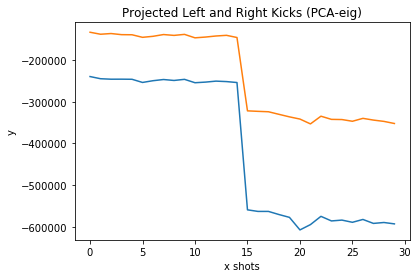

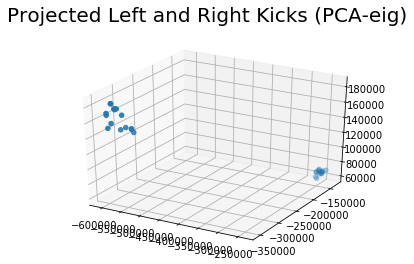

In [5]:
for i in [[(highs,lows), 'Highs+Lows: eigenvalue distribution (PCA-eig)','Projected  High and Low Kicks (PCA-eig)'],
          [(highs,rights),'Highs+Rights: eigenvalue distribution (PCA-eig)','Projected  High and Right Kicks (PCA-eig)'],
          [(highs,lefts),'Highs+Lefts: eigenvalue distribution (PCA-eig)','Projected  High and Left Kicks (PCA-eig)'],
          [(lows,rights),'Lows+Rights: eigenvalue distribution (PCA-eig)','Projected  Low and Right Kicks (PCA-eig)'],
          [(lows,lefts),'Lows+Lefts: eigenvalue distribution (PCA-eig)','Projected  Low and Left Kicks (PCA-eig)'],
          [(lefts,rights),'Lefts+Rights: eigenvalue distribution (PCA-eig)','Projected Left and Right Kicks (PCA-eig)'],
         ]:
    PCA_eig(i[0],i[1],i[2])

### Iteratively perform and plot PCA (using SVD) for each of the 6 pairs from (right,left,center_low, and center_high kicks).

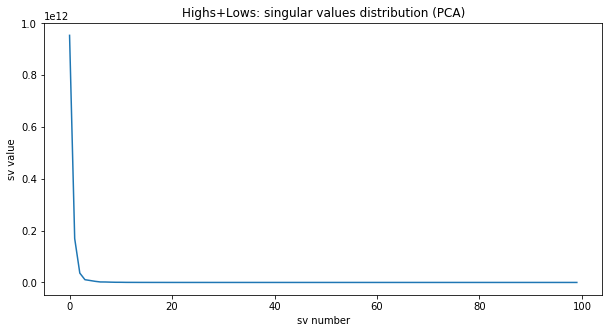

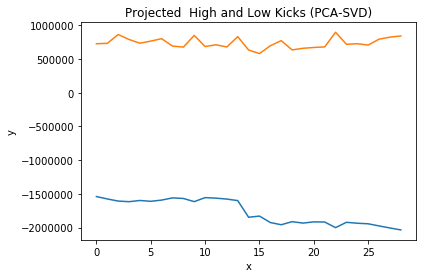

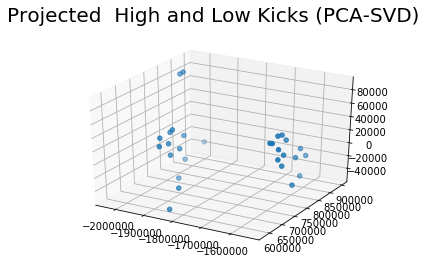

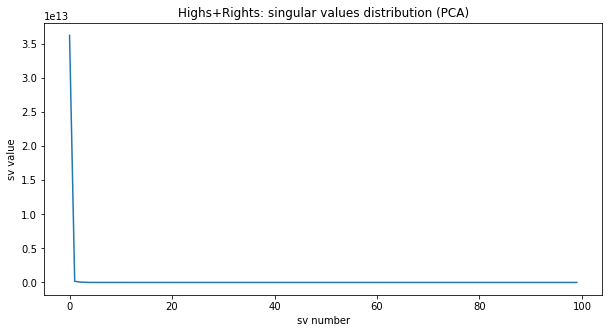

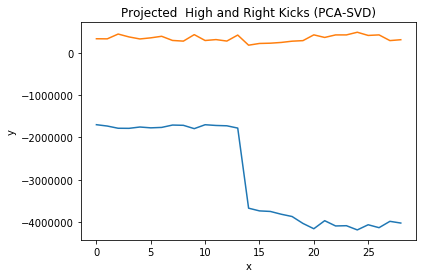

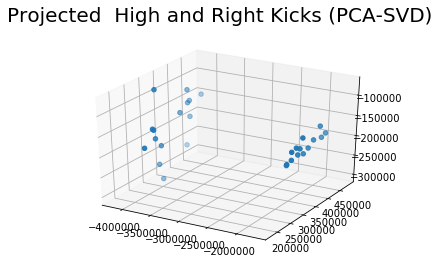

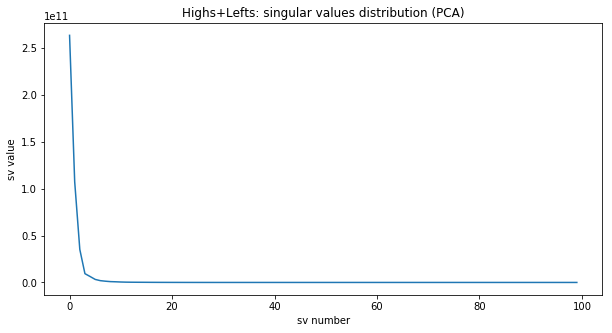

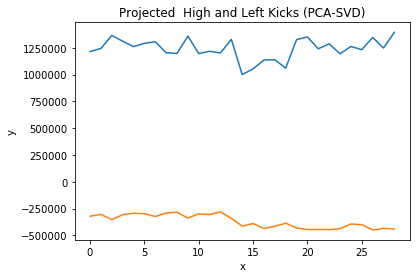

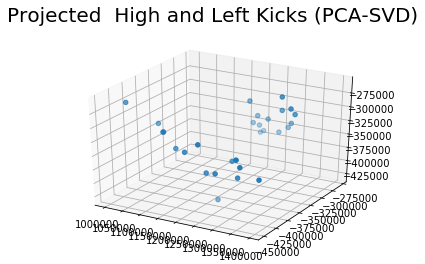

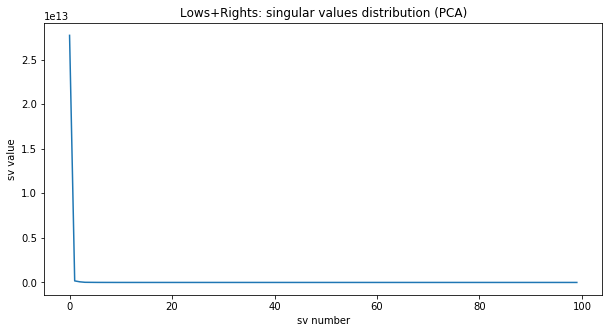

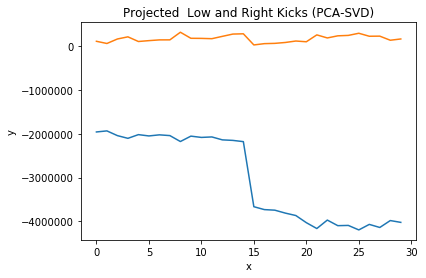

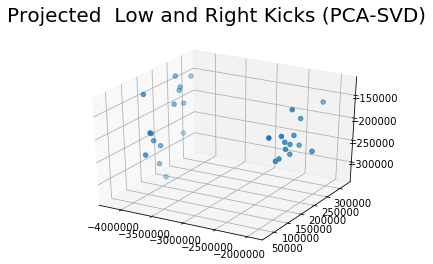

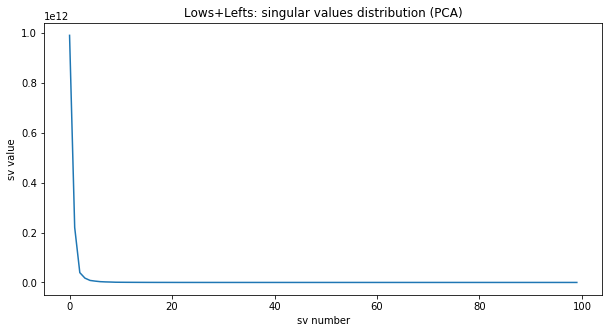

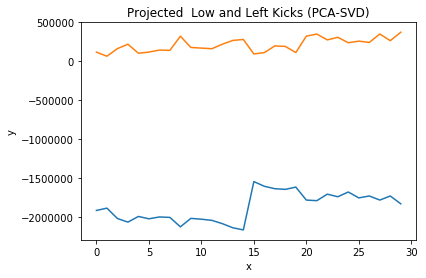

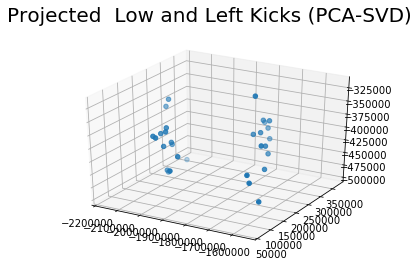

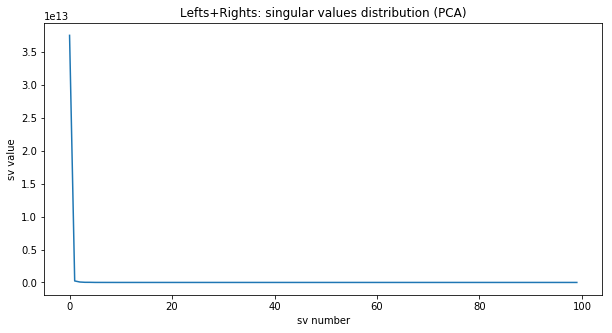

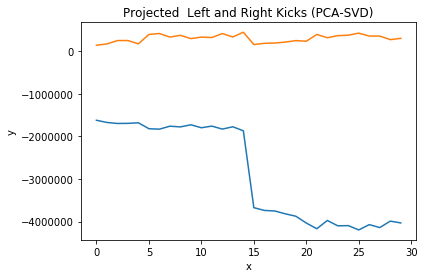

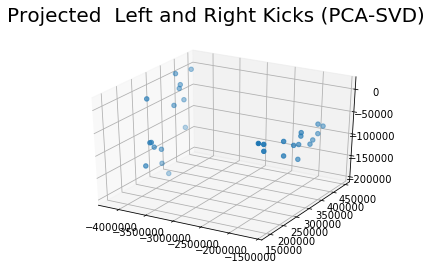

In [6]:
for i in [[(highs,lows), 'Highs+Lows: singular values distribution (PCA)','Projected  High and Low Kicks (PCA-SVD)'],
          [(highs,rights), 'Highs+Rights: singular values distribution (PCA)','Projected  High and Right Kicks (PCA-SVD)'],
          [(highs,lefts), 'Highs+Lefts: singular values distribution (PCA)','Projected  High and Left Kicks (PCA-SVD)'],
          [(lows,rights), 'Lows+Rights: singular values distribution (PCA)','Projected  Low and Right Kicks (PCA-SVD)'],
          [(lows,lefts), 'Lows+Lefts: singular values distribution (PCA)','Projected  Low and Left Kicks (PCA-SVD)'],
          [(lefts,rights), 'Lefts+Rights: singular values distribution (PCA)','Projected  Left and Right Kicks (PCA-SVD)'],
         ]:
    PCA_svd(i[0],i[1],i[2])


### Iteratively perform and plot PCA (using SVD) for each of the 4 triples from (right,left,center_low, and center_high kicks).

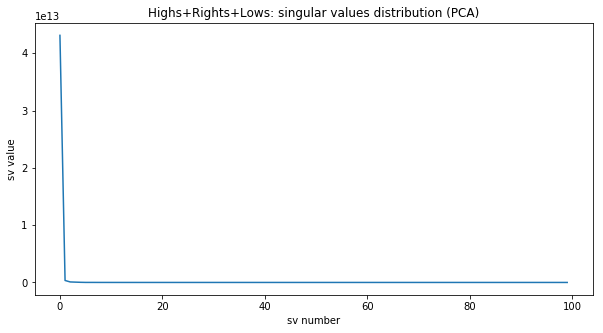

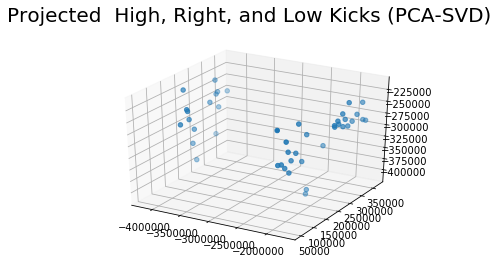

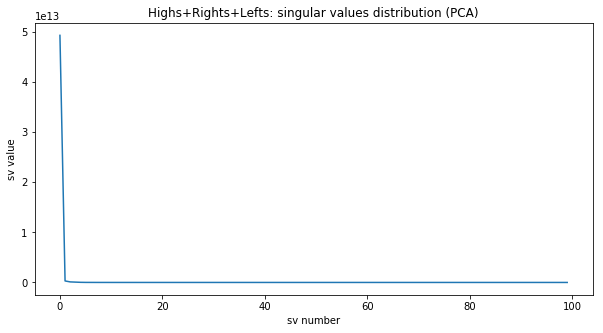

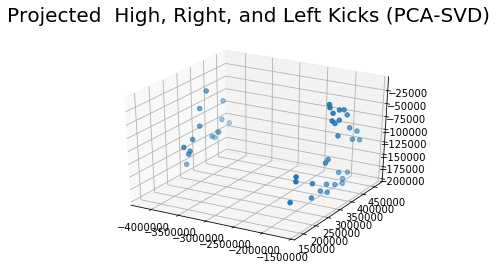

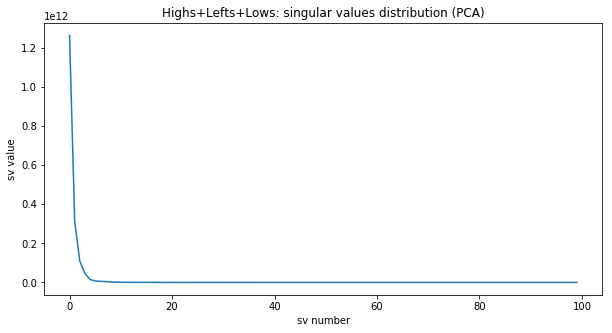

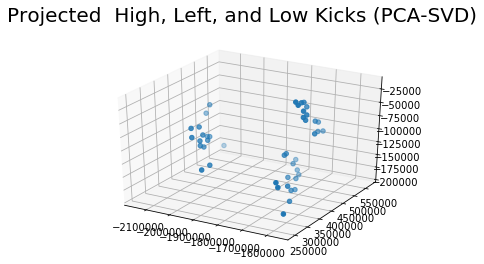

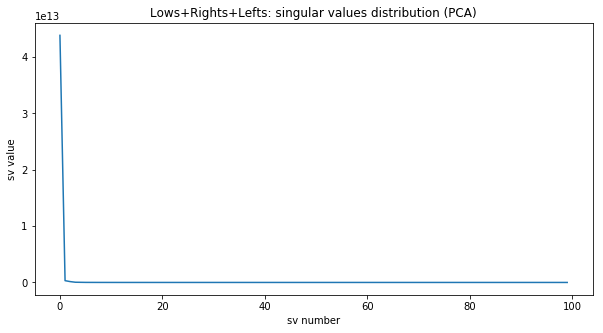

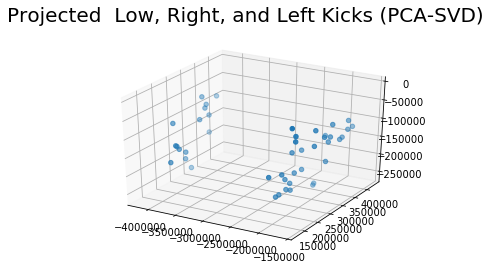

In [7]:
for i in [[(highs,rights,lows), 'Highs+Rights+Lows: singular values distribution (PCA)','Projected  High, Right, and Low Kicks (PCA-SVD)'],
          [(highs,rights,lefts), 'Highs+Rights+Lefts: singular values distribution (PCA)','Projected  High, Right, and Left Kicks (PCA-SVD)'],
          [(highs,lefts,lows), 'Highs+Lefts+Lows: singular values distribution (PCA)','Projected  High, Left, and Low Kicks (PCA-SVD)'],
          [(lows,rights,lefts), 'Lows+Rights+Lefts: singular values distribution (PCA)','Projected  Low, Right, and Left Kicks (PCA-SVD)'],
         ]:
    PCA_svd(i[0],i[1],i[2],threes=True)

### Perform and plot PCA (using SVD) for combined dataset of right,left,center_low, and center_high kicks.

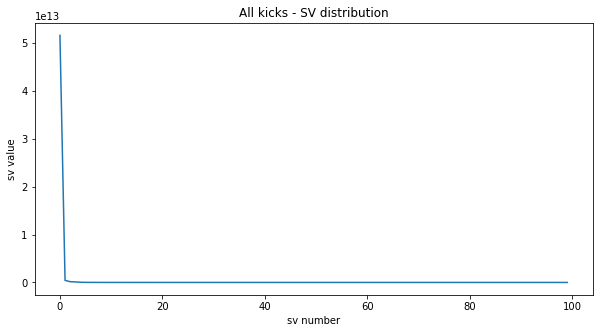

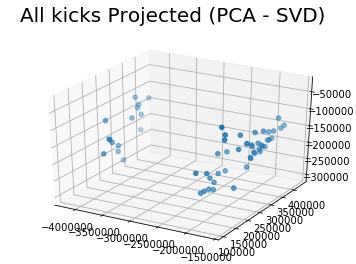

In [8]:
PCA_svd((lows,highs,rights,lefts),'All kicks - SV distribution','All kicks Projected (PCA - SVD)',threes=True)

# Clearly, projecting all 4 classes onto a 3 dimensional space using PCA will not help us...let's move on to LDA

### Iteratively perform and plot LDA for each of the 6 pairs from (right,left,center_low, and center_high kicks).

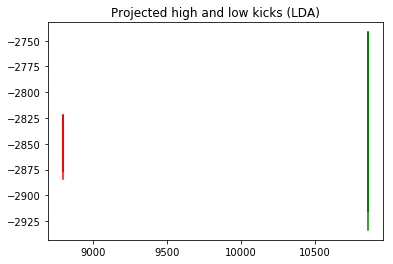

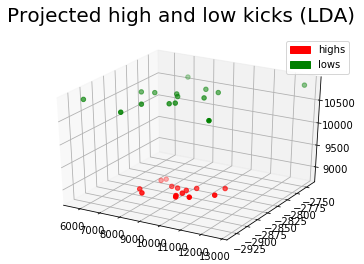

In [9]:
U_high_low = LDA((highs,lows))
Y1 = highs.dot(U_high_low[:,:3])
Y2 = lows.dot(U_high_low[:,:3])

plt.title('Projected high and low kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'red')
plt.plot(Y2[:,0],Y2[:,1],'green')
plt.show()
    
a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='r', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='g', depthshade=True)
r_patch = mpatches.Patch(color='red', label='highs')
b_patch = mpatches.Patch(color='green', label='lows')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected high and low kicks (LDA)', fontsize=20)

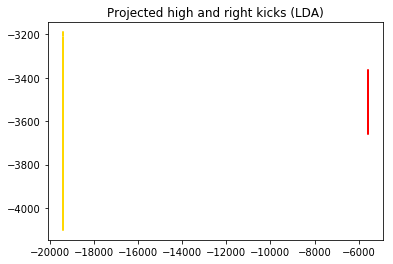

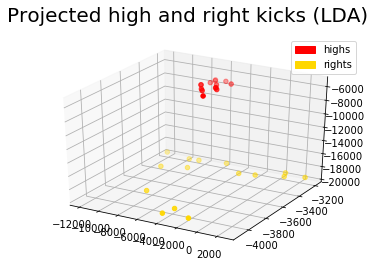

In [10]:
U_high_right = LDA((highs,rights))
Y1= highs.dot(U_high_right[:,:3])
Y2 = rights.dot(U_high_right[:,:3])

plt.title('Projected high and right kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'red')
plt.plot(Y2[:,0],Y2[:,1],'gold')
plt.show()
    
a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='r', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='gold', depthshade=True)
r_patch = mpatches.Patch(color='red', label='highs')
b_patch = mpatches.Patch(color='gold', label='rights')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected high and right kicks (LDA)', fontsize=20)

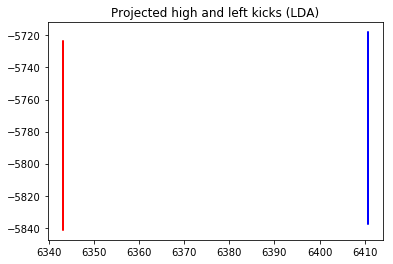

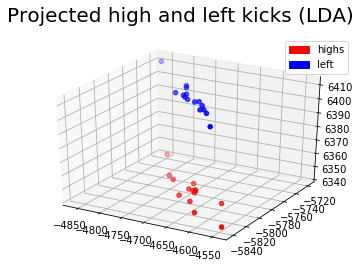

In [11]:
U_highs_lefts = LDA((highs,lefts))
Y1= highs.dot(U_highs_lefts[:,:3])
Y2 = lefts.dot(U_highs_lefts[:,:3])

plt.title('Projected high and left kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'red')
plt.plot(Y2[:,0],Y2[:,1],'blue')
plt.show()
    
a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='r', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='blue', depthshade=True)
r_patch = mpatches.Patch(color='red', label='highs')
b_patch = mpatches.Patch(color='blue', label='left')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected high and left kicks (LDA)', fontsize=20)

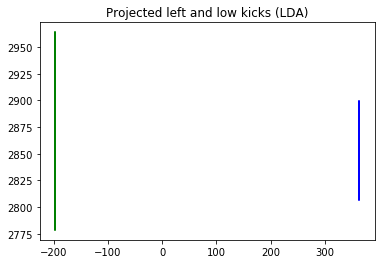

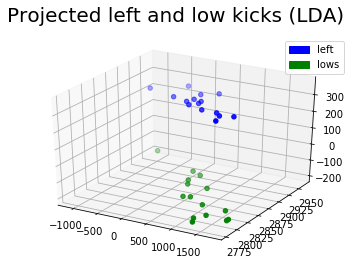

In [12]:
U_left_low = LDA((lefts,lows))
Y1= lefts.dot(U_left_low[:,:3])
Y2 = lows.dot(U_left_low[:,:3])

plt.title('Projected left and low kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'blue')
plt.plot(Y2[:,0],Y2[:,1],'green')
plt.show()

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='blue', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='green', depthshade=True)
r_patch = mpatches.Patch(color='blue', label='left')
b_patch = mpatches.Patch(color='green', label='lows')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected left and low kicks (LDA)', fontsize=20)

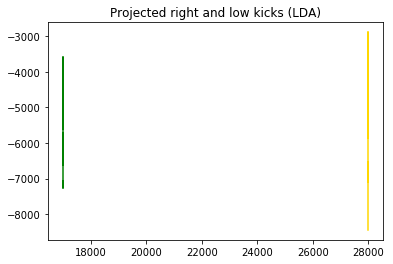

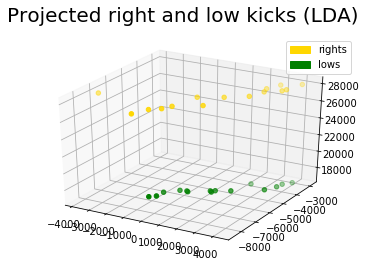

In [13]:
U_right_lows = LDA((rights,lows))
Y1= rights.dot(U_right_lows[:,:3])
Y2 = lows.dot(U_right_lows[:,:3])

plt.title('Projected right and low kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'gold')
plt.plot(Y2[:,0],Y2[:,1],'green')
plt.show()

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='gold', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='green', depthshade=True)
r_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='green', label='lows')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected right and low kicks (LDA)', fontsize=20)

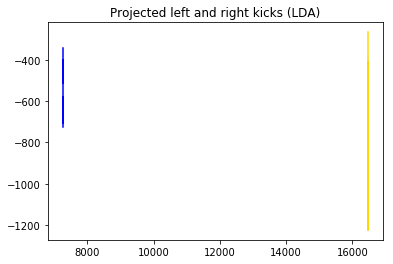

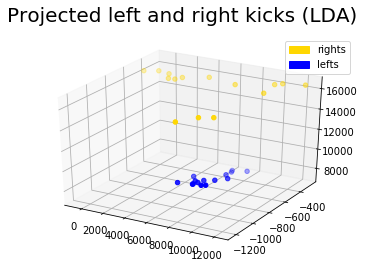

In [14]:
U_left_right= LDA((lefts,rights))
Y1 = lefts.dot(U_left_right[:,:3])
Y2 = rights.dot(U_left_right[:,:3])
plt.title('Projected left and right kicks (LDA)')
plt.plot(Y1[:,0],Y1[:,1],'blue')
plt.plot(Y2[:,0],Y2[:,1],'gold')
plt.show()

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
    zs=np.real(a1), zdir='z', s=20, c='blue', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
    zs=np.real(b1), zdir='z', s=20, c='gold', depthshade=True)
r_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='blue', label='lefts')
plt.legend(handles=[r_patch,b_patch])
fig.suptitle('Projected left and right kicks (LDA)', fontsize=20)

### Iteratively perform and plot LDA for each of the 4 triples from (right,left,center_low, and center_high kicks).

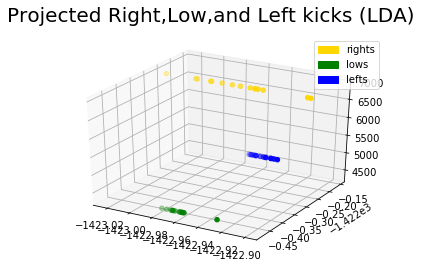

In [15]:
U_right_left_low = LDA((rights,lefts,lows))
Y1 = rights.dot(U_right_left_low[:,:3])
Y2 = lows.dot(U_right_left_low[:,:3])
Y3 = lefts.dot(U_right_left_low[:,:3])

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
#print(a1.shape,a2.shape,a3.shape,Y1.shape)
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
#print(b1.shape,b2.shape,b3.shape,Y2.shape)
c1=np.squeeze(np.asarray(Y3[:,0]))
c2=np.squeeze(np.asarray(Y3[:,1]))
c3=np.squeeze(np.asarray(Y3[:,2]))
#print(c1.shape,c2.shape,c3.shape,Y3.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
           zs=np.real(a1), zdir='z', s=20, c='gold', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
           zs=np.real(b1), zdir='z', s=20, c='green', depthshade=True)
ax.scatter(xs=np.real(c3), ys=np.real(c2), 
           zs=np.real(c1), zdir='z', s=20, c='blue', depthshade=True)
r_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='green', label='lows')
g_patch = mpatches.Patch(color='blue', label='lefts')
plt.legend(handles=[r_patch,b_patch,g_patch])
fig.suptitle('Projected Right,Low,and Left kicks (LDA)', fontsize=20)

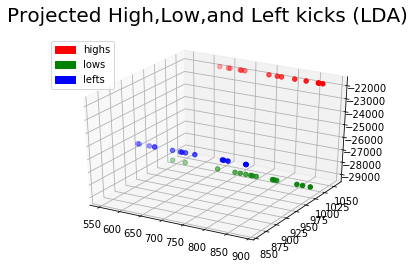

In [16]:
U_high_left_low = LDA((highs,lefts,lows))
Y1 = highs.dot(U_high_left_low[:,:3])
Y2 = lows.dot(U_high_left_low[:,:3])
Y3 = lefts.dot(U_high_left_low[:,:3])

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
#print(a1.shape,a2.shape,a3.shape,Y1.shape)
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
#print(b1.shape,b2.shape,b3.shape,Y2.shape)
c1=np.squeeze(np.asarray(Y3[:,0]))
c2=np.squeeze(np.asarray(Y3[:,1]))
c3=np.squeeze(np.asarray(Y3[:,2]))
#print(c1.shape,c2.shape,c3.shape,Y3.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
           zs=np.real(a1), zdir='z', s=20, c='red', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
           zs=np.real(b1), zdir='z', s=20, c='green', depthshade=True)
ax.scatter(xs=np.real(c3), ys=np.real(c2), 
           zs=np.real(c1), zdir='z', s=20, c='blue', depthshade=True)
r_patch = mpatches.Patch(color='red', label='highs')
b_patch = mpatches.Patch(color='green', label='lows')
g_patch = mpatches.Patch(color='blue', label='lefts')
plt.legend(handles=[r_patch,b_patch,g_patch])
fig.suptitle('Projected High,Low,and Left kicks (LDA)', fontsize=20)

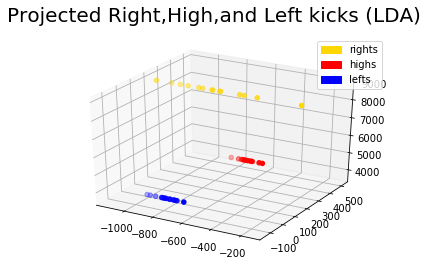

In [17]:
U_right_left_high = LDA((rights,lefts,highs))
Y1 = rights.dot(U_right_left_high[:,:3])
Y2 = highs.dot(U_right_left_high[:,:3])
Y3 = lefts.dot(U_right_left_high[:,:3])

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
#print(a1.shape,a2.shape,a3.shape,Y1.shape)
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
#print(b1.shape,b2.shape,b3.shape,Y2.shape)
c1=np.squeeze(np.asarray(Y3[:,0]))
c2=np.squeeze(np.asarray(Y3[:,1]))
c3=np.squeeze(np.asarray(Y3[:,2]))
#print(c1.shape,c2.shape,c3.shape,Y3.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
           zs=np.real(a1), zdir='z', s=20, c='gold', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
           zs=np.real(b1), zdir='z', s=20, c='red', depthshade=True)
ax.scatter(xs=np.real(c3), ys=np.real(c2), 
           zs=np.real(c1), zdir='z', s=20, c='blue', depthshade=True)
r_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='red', label='highs')
g_patch = mpatches.Patch(color='blue', label='lefts')
plt.legend(handles=[r_patch,b_patch,g_patch])
fig.suptitle('Projected Right,High,and Left kicks (LDA)', fontsize=20)

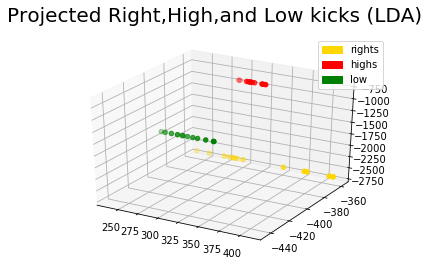

In [18]:
U_right_high_low = LDA((rights,highs,lows))
Y1 = rights.dot(U_right_high_low[:,:3])
Y2 = highs.dot(U_right_high_low[:,:3])
Y3 = lows.dot(U_right_high_low[:,:3])

a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
#print(a1.shape,a2.shape,a3.shape,Y1.shape)
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
#print(b1.shape,b2.shape,b3.shape,Y2.shape)
c1=np.squeeze(np.asarray(Y3[:,0]))
c2=np.squeeze(np.asarray(Y3[:,1]))
c3=np.squeeze(np.asarray(Y3[:,2]))
#print(c1.shape,c2.shape,c3.shape,Y3.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
           zs=np.real(a1), zdir='z', s=20, c='gold', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
           zs=np.real(b1), zdir='z', s=20, c='red', depthshade=True)
ax.scatter(xs=np.real(c3), ys=np.real(c2), 
           zs=np.real(c1), zdir='z', s=20, c='green', depthshade=True)
r_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='red', label='highs')
g_patch = mpatches.Patch(color='green', label='low')
plt.legend(handles=[r_patch,b_patch,g_patch])
fig.suptitle('Projected Right,High,and Low kicks (LDA)', fontsize=20)

### Perform and plot LDA for right,left,center_low, and center_high kicks.

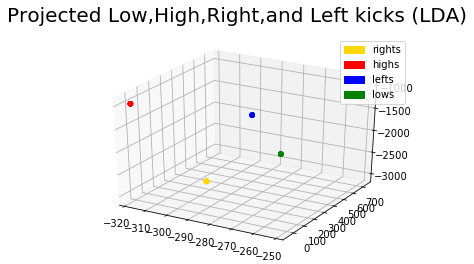

In [19]:
U_all = LDA((rights,highs,lows,lefts))
Y1 = lows.dot(U_all[:,:3])
Y2 = highs.dot(U_all[:,:3])
Y3 = lefts.dot(U_all[:,:3])
Y4 = rights.dot(U_all[:,:3])


a1=np.squeeze(np.asarray(Y1[:,0]))
a2=np.squeeze(np.asarray(Y1[:,1]))
a3=np.squeeze(np.asarray(Y1[:,2]))
#print(a1.shape,a2.shape,a3.shape,Y1.shape)
b1=np.squeeze(np.asarray(Y2[:,0]))
b2=np.squeeze(np.asarray(Y2[:,1]))
b3=np.squeeze(np.asarray(Y2[:,2]))
#print(b1.shape,b2.shape,b3.shape,Y2.shape)
c1=np.squeeze(np.asarray(Y3[:,0]))
c2=np.squeeze(np.asarray(Y3[:,1]))
c3=np.squeeze(np.asarray(Y3[:,2]))
#print(c1.shape,c2.shape,c3.shape,Y3.shape)
d1=np.squeeze(np.asarray(Y4[:,0]))
d2=np.squeeze(np.asarray(Y4[:,1]))
d3=np.squeeze(np.asarray(Y4[:,2]))
#print(d1.shape,d2.shape,d3.shape,Y4.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.real(a3), ys=np.real(a2), 
           zs=np.real(a1), zdir='z', s=20, c='g', depthshade=True)
ax.scatter(xs=np.real(b3), ys=np.real(b2), 
           zs=np.real(b1), zdir='z', s=20, c='r', depthshade=True)
ax.scatter(xs=np.real(c3), ys=np.real(c2), 
           zs=np.real(c1), zdir='z', s=20, c='b', depthshade=True)
ax.scatter(xs=np.real(d3), ys=np.real(d2), 
           zs=np.real(d1), zdir='z', s=20, c='gold', depthshade=True)
y_patch = mpatches.Patch(color='gold', label='rights')
b_patch = mpatches.Patch(color='blue', label='lefts')
r_patch = mpatches.Patch(color='red', label='highs')
g_patch = mpatches.Patch(color='green', label='lows')
plt.legend(handles=[y_patch,r_patch,b_patch,g_patch])
fig.suptitle('Projected Low,High,Right,and Left kicks (LDA)', fontsize=20)

### The above graph is difficult to rely on since we are dealing with a 4-class classification problem, and we are projecting the data onto a 3-D space. I've already visualized nice pair-wise and triple-wise separation with my LDA classifier, and earlier PCA did a decent job with clustering. Now, 1) let's split some of our trials into training and test sets, 2) use sklearn's LDA fit/predict functionality, and 3) an error measure, like MSE, to assess the accuracy of my data's classification. I think using the external package successfully also adds reinforcement to the correctness of my earlier implementation. 

### And looking forward, knowing we can classify intent of the penalty kick, I would look to divide the soccer goal into a, say, 3x3 grid of targets in order to constrain the variation of successful shots. (Ignoring the goalkeeper for a moment, think of the location variation of a penalty-kick vs a basketball free throw. The ball from a successful penalty kick has more possible locations in space than the ball from a successful free throw due to the inherent size of the targets - goal post vs basketball hoop.) Then, using an advanced machine learning classifier and a large, accurate dataset generated from advanced, accurate soccer player(s) with N kicks in each of the 9 directions (if we choose a 3x3 grid of targets, but this can be more or less granular depending on how the results/research progress), we can predict more/less where the penalty kick landed. 

### Thinking of free-throw prediction as a binary classifcation problem at the surface (success or fail | 0 or 1), a penalty kick is also a binary classification problem at the surface with the caveat that it has greater variation due to a wider target space and defense from a keeper. Therefore, if we limit variation by predicting where the penalty kick more/less landed, then we can start to think about the keeper. At this point, we can put an accelerometer in the keeper's glove. For each trial (penalty kick), you would record ACC data from both the penalty kicker's boot and goalkeeper's glove concurrently, and combine these same-length samples into 1 example of M examples (from M trials) for a supervised learning problem where some sort of advanced feature engineering would be performed on each example of combined goalkeeper-glove and penalty-kicker-boot ACC data. Hopefully, this feature engineering would, like our hypothesized earlier classifier, determine, at some granularity, the "point" where the ball would cross (or fail to cross) the plane of the goal, and the space near the plane of the goal that the glove covered. Because we imagine these features as input to a supervised learning problem with a research-grade dataset from top kickers and top keepers, I think only then would binary-classification of a penalty kick be possible, foreshadowing how much more difficult of a problem binary, penalty-kick classification (or simply penalty-kick success prediction) is as opposed to binary, free-throw classification (or simply free-throw success prediction). I might guess that if one were to enforce recording of goalkeeper-glove and penalty-kicker-boot ACC data similarly to as described above in the top European leagues and other top leagues for penalty kicks across a span of years, unsupervised learning approaches might emerge as well, and I would imagine that this scenario would enable the development of a powerful supervised model for penalty-kick success prediction. 

<img src='multiclass.png'>

In [20]:
#####################################################################################################################

In [21]:
train_X = np.vstack((highs[:10],lows[:10],lefts[:10],rights[:10]))
train_y = np.hstack((np.zeros(highs[:10].shape[0]),(np.zeros(lows[:10].shape[0])+1),
                     (np.zeros(lefts[:10].shape[0])+2),(np.zeros(rights[:10].shape[0])+3)))

In [22]:
test_X = np.vstack((highs[10:],lows[10:],lefts[10:],rights[10:]))
test_y = np.hstack((np.zeros(highs[10:].shape[0]),(np.zeros(lows[10:].shape[0])+1),
                     (np.zeros(lefts[10:].shape[0])+2),(np.zeros(rights[10:].shape[0])+3)))

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error as mse
clf = LinearDiscriminantAnalysis()
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
error= mse(test_y, pred_y)

print('Accuracy using sklearn LDA:',(1-error)*100,'%','\npredictions:',pred_y)

Accuracy using sklearn LDA: 100.0 % 
predictions: [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.
  3.]
